In [1]:
!pip install -q tensorflow==2.0.0-beta1

tensorflow-serving-api 1.14.0 has requirement tensorflow~=1.14.0, but you'll have tensorflow 2.0.0b1 which is incompatible.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install -q statsmodels==0.9.0

tensorflow-serving-api 1.14.0 has requirement tensorflow~=1.14.0, but you'll have tensorflow 2.0.0b1 which is incompatible.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install -q scipy==1.2

tensorflow-serving-api 1.14.0 has requirement tensorflow~=1.14.0, but you'll have tensorflow 2.0.0b1 which is incompatible.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
!pip install -q pyramid.arima

tensorflow-serving-api 1.14.0 has requirement tensorflow~=1.14.0, but you'll have tensorflow 2.0.0b1 which is incompatible.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
import os
import csv
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler

In [6]:
import boto3 
import botocore 
import pandas as pd 
from sagemaker import get_execution_role 

role = get_execution_role() 

bucket = 'oildatabucket' 
data_key = 'BrentOilPrices.csv'
data_location = 's3://{}/{}'.format(bucket, data_key) 

df = pd.read_csv(data_location)

In [7]:
from pandas import DataFrame

In [8]:
tseries=df['Price']
tseries

0       18.63
1       18.45
2       18.55
3       18.60
4       18.63
5       18.60
6       18.60
7       18.58
8       18.65
9       18.68
10      18.75
11      18.78
12      18.65
13      18.75
14      18.78
15      18.78
16      18.68
17      18.78
18      18.90
19      19.03
20      19.05
21      19.05
22      19.10
23      18.90
24      18.75
25      18.70
26      19.08
27      19.15
28      19.08
29      18.98
        ...  
8186    59.03
8187    60.60
8188    59.81
8189    58.64
8190    58.64
8191    58.44
8192    60.42
8193    60.59
8194    61.04
8195    58.55
8196    57.93
8197    60.68
8198    62.70
8199    61.28
8200    63.99
8201    64.67
8202    63.02
8203    60.76
8204    61.25
8205    68.42
8206    65.59
8207    64.29
8208    64.25
8209    65.23
8210    64.66
8211    64.13
8212    62.41
8213    62.08
8214    62.48
8215    60.99
Name: Price, Length: 8216, dtype: float64

In [9]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(tseries)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.954749
p-value: 0.306759
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [10]:
tsdiff=np.log(tseries)

In [11]:
result = adfuller(tsdiff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.613410
p-value: 0.476186
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


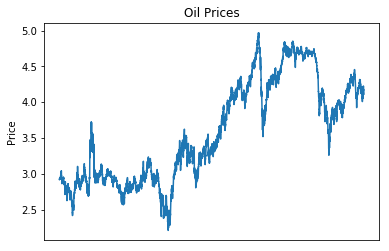

In [12]:
import matplotlib.pyplot as plt
plt.plot(tsdiff)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('Price')
plt.title("Oil Prices")
plt.show()

In [13]:
df=pd.DataFrame(tsdiff)
df

,Price
0,2.924773
1,2.915064
2,2.920470
3,2.923162
4,2.924773
5,2.923162
6,2.923162
7,2.922086
8,2.925846
9,2.927453


In [14]:
# Form dataset matrix
def create_dataset(df, previous=1):
    dataX, dataY = [], []
    for i in range(len(df)-previous-1):
        a = df[i:(i+previous), 0]
        dataX.append(a)
        dataY.append(df[i + previous, 0])
    return np.array(dataX), np.array(dataY)

In [15]:
df=np.array(df)

In [16]:
df

array([[2.92477318],
       [2.91506437],
       [2.92046979],
       ...,
       [4.12842388],
       [4.13484651],
       [4.11070992]])

In [17]:
# normalize dataset with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)
df

array([[0.25948897],
       [0.2559728 ],
       [0.25793044],
       ...,
       [0.69540609],
       [0.69773213],
       [0.68899076]])

In [18]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# Training and Validation data partition
train_size = int(len(df) * 0.8)
val_size = len(df) - train_size
train, val = df[0:train_size,:], df[train_size:len(df),:]

# Number of previous
previous = 500
X_train, Y_train = create_dataset(train, previous)
X_val, Y_val = create_dataset(val, previous)

In [19]:
X_train

array([[0.25948897, 0.2559728 , 0.25793044, ..., 0.26945914, 0.26431659,
        0.2797141 ],
       [0.2559728 , 0.25793044, 0.25890531, ..., 0.26431659, 0.2797141 ,
        0.27415651],
       [0.25793044, 0.25890531, 0.25948897, ..., 0.2797141 , 0.27415651,
        0.26277874],
       ...,
       [0.94306793, 0.94274392, 0.95262698, ..., 0.87933295, 0.88254847,
        0.88504519],
       [0.94274392, 0.95262698, 0.95308549, ..., 0.88254847, 0.88504519,
        0.88094428],
       [0.95262698, 0.95308549, 0.93808763, ..., 0.88504519, 0.88094428,
        0.87016019]])

In [20]:
Y_train

array([0.27415651, 0.26277874, 0.26718257, ..., 0.88094428, 0.87016019,
       0.8655946 ])

In [ ]:
from tensorflow.keras.layers import Dropout

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

# Generate LSTM network
model = tf.keras.Sequential()
model.add(LSTM(4, input_shape=(1, previous)))
# model.add(Dropout(0.8))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=1, verbose=2)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Train on 4856 samples, validate on 1215 samples
Epoch 1/100
4856/4856 - 10s - loss: 0.0028 - val_loss: 0.0046
Epoch 2/100
4856/4856 - 9s - loss: 0.0019 - val_loss: 0.0027
Epoch 3/100
4856/4856 - 9s - loss: 0.0013 - val_loss: 0.0024
Epoch 4/100
4856/4856 - 9s - loss: 0.0011 - val_loss: 0.0045
Epoch 5/100
4856/4856 - 9s - loss: 8.9471e-04 - val_loss: 0.0033
Epoch 6/100
4856/4856 - 9s - loss: 8.5405e-04 - val_loss: 0.0058
Epoch 7/100
4856/4856 - 17s - loss: 8.0468e-04 - val_loss: 0.0098
Epoch 8/100
4856/4856 - 24s - loss: 6.6785e-04 - val_loss: 0.0013
Epoch 9/100
4856/4856 - 30s - loss: 7.5776e-04 - val_loss: 0.0030
Epoch 10/100
4856/4856 - 24s - loss: 6.9055e-04 - val_loss: 0.0021
Epoch 11/100
4856/4856 - 24s - loss: 6.5734e-04 - val_loss: 0.0017
Epoch 12/100
4856/4856 - 24s - loss: 7.7566e-04 - val_loss: 0.0028
Epoch 13/100
4856/4856 - 24s - loss: 6.2066e-04 - val_loss: 0.0035
Epoch 14/100
4856/4856 - 24s - loss: 6.9680e-04 - val_loss: 0.0045
Epoch 15/100
4856/4856 - 24s - loss: 6.6578e

In [ ]:
# Generate predictions
trainpred = model.predict(X_train)
valpred = model.predict(X_val)

In [ ]:
trainpred

In [ ]:
valpred

In [ ]:
# Convert predictions back to normal values
trainpred = scaler.inverse_transform(trainpred)
Y_train = scaler.inverse_transform([Y_train])
valpred = scaler.inverse_transform(valpred)
Y_val = scaler.inverse_transform([Y_val])
predictions = valpred

In [ ]:
import math
from sklearn.metrics import mean_squared_error

# calculate RMSE
trainScore = math.sqrt(mean_squared_error(Y_train[0], trainpred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(Y_val[0], valpred[:,0]))
print('Validation Score: %.2f RMSE' % (valScore))

In [ ]:
# Train predictions
trainpredPlot = np.empty_like(df)
trainpredPlot[:, :] = np.nan
trainpredPlot[previous:len(trainpred)+previous, :] = trainpred

In [ ]:
# Validation predictions
valpredPlot = np.empty_like(df)
valpredPlot[:, :] = np.nan
valpredPlot[len(trainpred)+(previous*2)+1:len(df)-1, :] = valpred

In [ ]:
# Plot all predictions
inversetransform, =plt.plot(scaler.inverse_transform(df))
trainpred, =plt.plot(trainpredPlot)
valpred, =plt.plot(valpredPlot)
plt.xlabel('Number of weeks')
plt.ylabel('Cancellations')
plt.title("Predicted vs. Actual Oil Price (Stationary)")
plt.show()

In [ ]:
Y_val=Y_val.reshape(-1)
Y_val.shape
Y_val=pd.Series(Y_val)

In [ ]:
Y_val

In [ ]:
predictions=predictions.reshape(-1)
predictions.shape
predictions=pd.Series(predictions)

In [ ]:
predictions

In [ ]:
import numpy as np

def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

In [ ]:
mda(Y_val, predictions)

In [ ]:
# https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python/

from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(Y_val, predictions)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

In [ ]:
forecast_error = (predictions-Y_val)
forecast_error

In [ ]:
mean_forecast_error = np.mean(forecast_error)
mean_forecast_error